# reading TabCorr file and applying baryonic effects

In [1]:
import numpy as np

from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt

import pandas as pd

import time

from scipy.interpolate import splrep, splev
from scipy.integrate import quad

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog,FakeSim, CachedHaloCatalog
from halotools.mock_observables import delta_sigma, wp, return_xyz_formatted_array
from halotools.empirical_models import NFWProfile
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.utils import add_halo_hostid
from halotools.mock_observables.surface_density.surface_density_helpers import annular_area_weighted_midpoints

import baryonification as bfc
from baryonification.useful_functions import DeltaSigmas_from_density_profile, cvir_fct

from tabcorr import TabCorr

from astropy.cosmology import Planck15


In [2]:
data_directory = '/Users/fardila/Documents/Data/baryonic_effects/CMASS/'
queried_halo_cat_file = 'halo_catalogs/mdpl2_hlist_0.65650_Mvir11.2.csv'
test_halo_cat_file = 'halo_catalogs/test.csv'
### "row_id","Mvir","Rvir","M200c","M500c","x","y","z","scale"
# full_halo_cat_file = 'halo_catalogs/cut_halo_df.pkl'
particle_cat_file = 'particle_catalogs/mdpl2_particles_0.6565_10m.dat'
test_particle_cat_file = 'particle_catalogs/test.dat'
### "x","y","z"
displacedA_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_A.out'
displacedB_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_B.out'
displacedC_particle_cat_file = 'particle_catalogs/MDPL2_bfc_particles_C.out'

In [3]:
redshift = (1./0.65650)-1. #z=0.523
Lbox = 1000. #Mpc/h

# read in halo catalog 

In [4]:
# halo_df = pd.read_csv(data_directory+queried_halo_cat_file)

### read in TabCorr file

In [5]:
# We could read it in like this. Thus, we can skip the previous steps in the
# future.
halotab = TabCorr.read('mdpl2_tabCorr_DS.hdf5')

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [6]:
# Now, we're ready to calculate correlation functions for a specific model.
HOD_model = PrebuiltHodModelFactory('zheng07', redshift = redshift, cosmology=Planck15, populate=False,
                                         secondary_haloprop_key='halo_nfw_conc')



In [7]:
def hod_model_from_params(params, HOD_model):
    
    HOD_model.param_dict['logMmin'] = params[0]
    HOD_model.param_dict['sigma_logM'] = params[1]
    HOD_model.param_dict['logM0'] = params[2]
    HOD_model.param_dict['logM1'] = params[3]
    HOD_model.param_dict['alpha'] = params[4]
    
    return HOD_model

In [13]:
HOD_params = [13.031,0.38,13.27,14.08,0.76] #params from https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract

HOD_model = hod_model_from_params(HOD_params, HOD_model)




ngal, ds = halotab.predict(HOD_model)


In [14]:
baryonic_params = [6.6e13, 0.21, 4.0] #[Mc, mu, thej]

ngal, ds_baryons = halotab.predict_with_baryons(HOD_model,baryonic_params)

Normalizing power-spectrum done!


In [12]:
rbin = annular_area_weighted_midpoints(np.logspace(-1, 1, 20))

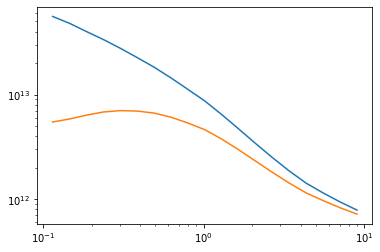

In [17]:
plt.plot(rbin,ds)
plt.plot(rbin, ds_baryons)
plt.loglog()
plt.show()

addeed TabCorr function `predict_with_baryons` which also takes baryonic params and calculates correction factor to DS profile and returns corrected profile.